Введение
==
<a id='intro'></a>

В данном ноутбуке рассматриваются три подхода к вычислению расстояния между двумя траекториями. Так как цели сравнения траекторий могут быть разными, то к функциям расстояния могут выдвигаться разные требования. В данном ноутбуке алгоритмы описаны в следующем порядке: 

1. Метрика Хаусдорфа.

2. Расстояние Фреше.

3. Наивный алгоритм.

В начале каждого раздела дается формальное описание алгоритма и оценивается его сложность. Реализации алгоритмов можно найти в файлах: `my_hausdorff.py`, `my_frechet.py`, `my_naive.py`.

Чтение данных
==

In [1]:
from split import split_track
from my_hausdorff import my_hausdorff_dst, illustrate_hausdorff
from my_frechet import my_frechet_dst, illustrate_frechet
from my_naive import my_naive_dst, illustrate_naive
from draw import *
import csv
import numpy as np

Считаем данные из файла ```test.csv``` в списки точек ```point_lists```

In [2]:
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

file_name = 'tracks.csv'
point_lists = []
with open(file_name, encoding='utf-8') as r_file:
    reader = csv.reader(r_file, delimiter=';')
    next(reader)
    for row in reader:
        i, time, x, y = row
        if int(i) != len(point_lists):
            point_lists.append([])
        point_lists[-1].append([get_sec(time), x, y])

Переведем каждую траекторию в ```np.array``` и сформируем список траекторий. 

Если бы точки траекторий в файле располагались не в хронологическом порядке, то их следовало бы отсортировать по времени наблюдения. Для этого достаточно раскомментировать соответствующую строку

In [3]:
original_tracks = []
for list in point_lists:
    #list.sort(key=lambda p: p[0])
    original_tracks.append(np.array(list, dtype=np.float64)[:, [1,2]]) 

Теперь ```original_tracks[i]``` – массив точек с координатами типа ```np.float64```, принадлежащих ```i+1```-ой траектории. Отрисуем считанные траектории.

Траектрии на рисунке ниже:

1 – белая;

2 – синяя;

3 – красная;

4 – зеленая.


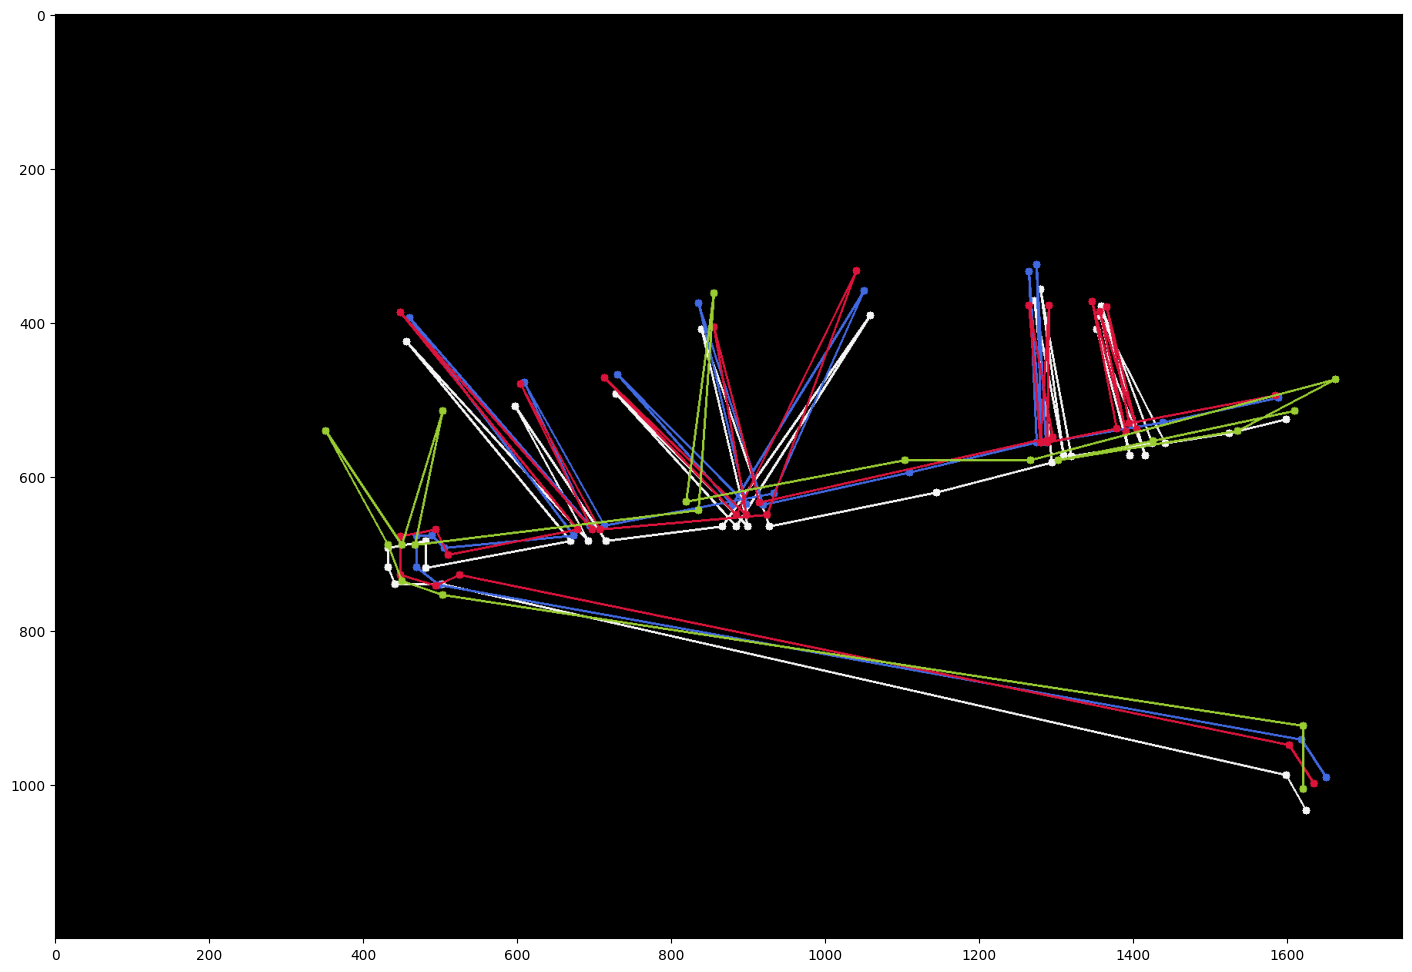

In [4]:
shape = (1200, 1750, 3)
original_tracks_img = np.zeros(shape, np.uint8)
original_tracks_img = draw_tracks(original_tracks_img, original_tracks)
show_img(original_tracks_img)

Теперь разделим каждую траекторию на более мелкие сегменты. Для этого воспользуемся функцией ```split_track(track, delta)```, которая делит каждый сегмент траектории ```track``` на отрезки длины $\leqslant$ ```delta```. Реализацию данной функции см. в модуле ```split```. Обоснование данного шага можно найти ниже.

In [5]:
delta = 40
tracks = []
for i in range(len(original_tracks)):
    track = split_track(original_tracks[i], delta)
    tracks.append(track)

Для большей наглядности далее будем отрисовывать только траектории 1 и 4. 

Белым цветом выделена тракетория 1, синим – трактория 4.

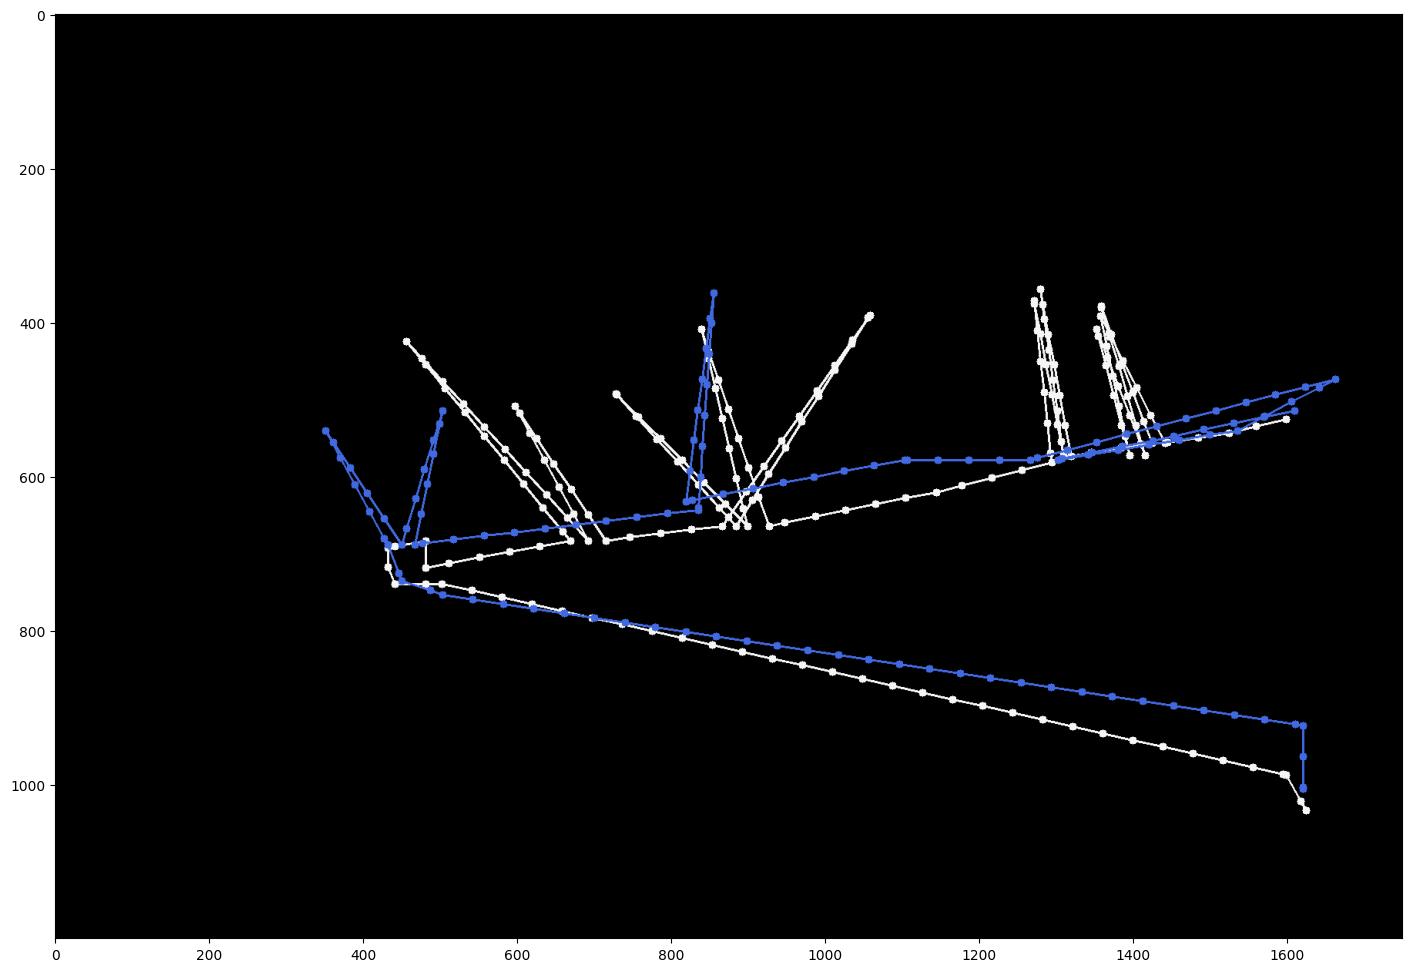

In [6]:
tracks14_img = np.zeros(shape, np.uint8)
tracks14_img = draw_tracks(tracks14_img, [tracks[0], tracks[3]])
show_img(tracks14_img)

Метрика Хаусдорфа
==

В качестве материалов использовались ресурсы:

- [В.А. Скворцов. "Примеры метрических пространств"](https://www.mccme.ru/mmmf-lectures/books/books/book.16.pdf)

- [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance)

- [An Efficient Algorithm for Calculating the Exact Hausdorff Distance](https://pypi.org/project/hausdorff/)

**Описание алгоритма:**

Пусть $P = (v_1, ..., v_p), Q = (u_1, ..., u_q)$ – две траектории, переданные на вход алгоритму, a $d(x,y)$ – расстояние между точками, вычисленное по функции ```metric```.

1. Вычисляются значения: 
$d(P, Q) = \max_{v_i \in P }\{d(v_i, Q)\}$,
$d(Q, P) = \max_{u_i \in Q }\{d(u_i, P)\}$,

    где $d(x, Y) := \min_{y_i \in Y} \{ d(x,y) \}$.

    Данные расстояния вычисляются с помощью ```KDTree``` из ```sklearn```.

2. Возвращаемое расстояние между траекториями есть $\max\{ d(P, Q), d(Q, P)\}$.


**Оценка времени работы:**

Если $|P|, |Q|$ – размеры траекторий, то ожидается, что построение k-d-деревьев на них занимает $O(|P| \log |P|)$ и $O(|Q| \log |Q|)$, соответственно. Вычисление расстояния $d(P, Q)$ требует $|P|$ запросов к дереву на $Q$, каждый из которых занимает $O(\log |Q|)$ времени. Итого: $O(|P| \log |Q|)$ и $O(|Q| \log |P|)$.

Суммарно алгоритм потребует $O(\max\{ |P|, |Q|\} \cdot \log \max\{|P|, |Q|\})$ времени.

Для вычисления расстояния по Хаусдорфу воспользуемся функцией ```my_hausdorff_dst(track_1, track_2, metric)```, которая принимает две траектории и метрику на множестве точек (по умолчанию ```'euclidean'```)

In [7]:
h_dst_1_4 = my_hausdorff_dst(tracks[0], tracks[3])
print('Расстояние по Хаусдорфу между траекториями 1 и 4  =', '%.3f' % h_dst_1_4)

Расстояние по Хаусдорфу между траекториями 1 и 4  = 212.177


Можно проиллюстрировать работу алгоритма с помощью функции ```illustrate_hausdorff(img, track_1, track_2)```.

Каждый красный отрезок соединяет точку траектории ```track_1``` с ближайшей к ней точкой траектории ```track_2```.

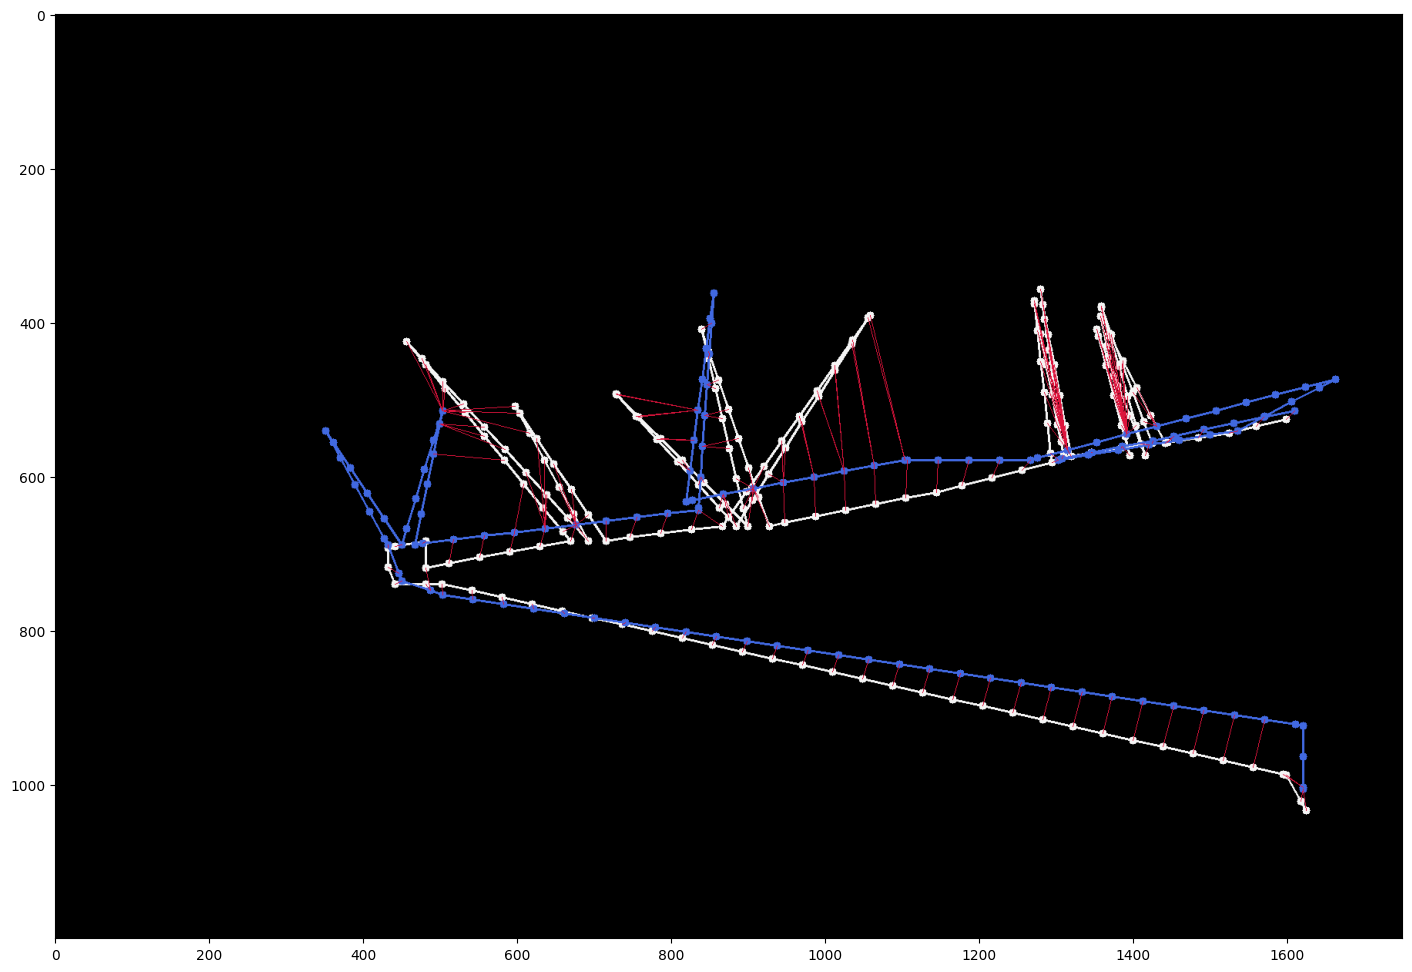

In [8]:
tracks14_hausdorff_img = tracks14_img.copy()
illustrate_hausdorff(tracks14_hausdorff_img, tracks[0], tracks[3])
show_img(tracks14_hausdorff_img)

Вычислим все попарные расстояния по Хаусдорфу между полученными траекториями. Через $H(i,j)$ обозначим расстояние между $i$-ой и $j$-ой траекториями.

In [9]:
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        h_dst = my_hausdorff_dst(tracks[i], tracks[j])
        print('H(', i + 1, ',', j + 1, ') = ', '%.3f' % h_dst)

H( 1 , 2 ) =  94.205
H( 1 , 3 ) =  60.729
H( 1 , 4 ) =  212.177
H( 2 , 3 ) =  96.323
H( 2 , 4 ) =  244.048
H( 3 , 4 ) =  194.799


В качестве некоторой проверки работоспособности реализации алгоритма можно сравнить полученные результаты с результатами работы библиотечного алгоритма. Полученные расстояния обозначим через $H'(i,j)$

In [10]:
%pip install hausdorff


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from hausdorff import hausdorff_distance

In [12]:
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        h_dst = hausdorff_distance(tracks[i], tracks[j])
        print('H\'(', i + 1, ',', j + 1, ') = ', '%.3f' % h_dst)

H'( 1 , 2 ) =  94.205
H'( 1 , 3 ) =  60.729
H'( 1 , 4 ) =  212.177
H'( 2 , 3 ) =  96.323
H'( 2 , 4 ) =  244.048
H'( 3 , 4 ) =  194.799


Как можно заметить, для всех $i,j$ значения $H(i,j)$ и $H'(i,j)$ совпадают.


Зачем разбивать траектории на меньшие отрезки?
---

Так как расстояние по Хаусдорфу не учитывает порядок следования точек в траекториях, то можно предположить, что мы хотим сравнивать две кривые $P, \, Q$ как подмножества $\mathbb{R}^2$. Тогда есть смысл "добавить" точек внутрь наших кривых. 

На примере ниже расстояние по Хаусдорфу между траекториями $P, Q$ равно длине длинного красного отрезка, соединяющего точки $[400, 200]$ и $[700, 500]$.

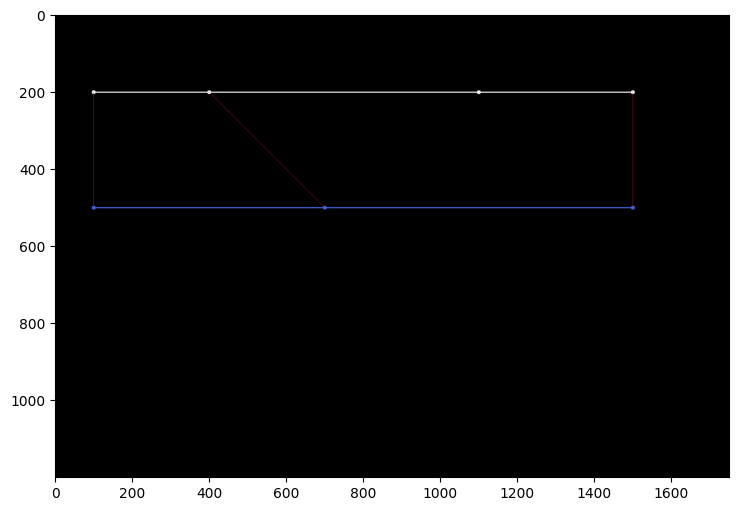

H(P, Q) = 500.000


In [13]:
P = np.array([[100, 200], [400, 200], [1100, 200], [1500, 200]])
Q = np.array([[100, 500], [700, 500], [1500, 500]])
P_Q_hausdorff_img = draw_tracks(np.zeros(shape, np.uint8), [P, Q])
illustrate_hausdorff(P_Q_hausdorff_img, Q, P)
show_img(P_Q_hausdorff_img, (9, 6))
P_Q_dst = my_hausdorff_dst(P, Q) # 500.0
print('H(P, Q) =', '%.3f' % P_Q_dst)

Хотя кажется, что расстояние между этими прямыми должно быть равно $\Delta y = 300$ (или близко к нему)

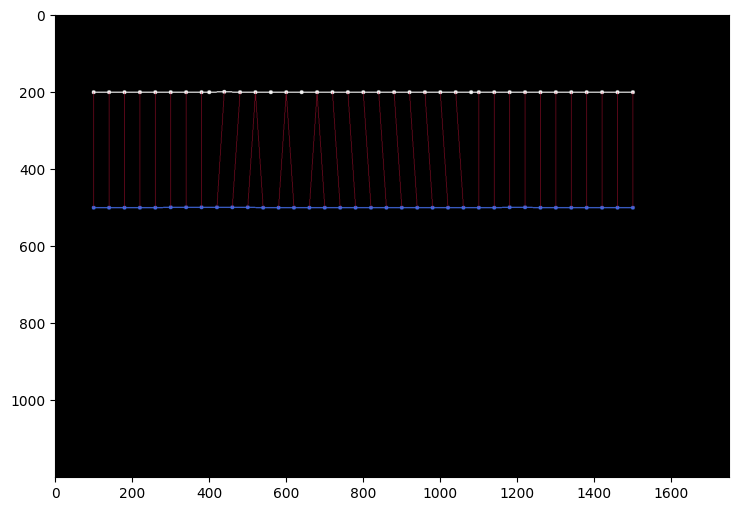

H(s_P, s_Q) = 300.666


In [14]:
delta = 40
s_P = split_track(P, delta)
s_Q = split_track(Q, delta)
s_P_Q_hausdorff_img = draw_tracks(np.zeros(shape, np.uint8), [s_P, s_Q])
illustrate_hausdorff(s_P_Q_hausdorff_img, s_Q, s_P)
show_img(s_P_Q_hausdorff_img, (9,6))
s_P_Q_dst = my_hausdorff_dst(s_P, s_Q) # 300.666
print('H(s_P, s_Q) =', '%.3f' % s_P_Q_dst)

Сравним расстояния между траекториями в исходном виде и после разбиения.

 Можно заметить, что расстояние между похожими траекториями 1 и 3, 2 и 3 стало меньше, в то время как расстояние от траектории 4 до остальных осталось достаточно большим. Данное свойство потенциально может позволить точнее классифицировать траектории.

In [15]:
print('Hausdorff distance:')
print('i j  ', 'original', ' splitted')
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        splitted_h_dst = my_hausdorff_dst(tracks[i], tracks[j])
        original_h_dst = my_hausdorff_dst(original_tracks[i], original_tracks[j])
        print(i + 1, j + 1, ' ', '%.3f' % original_h_dst, ' ', '%.3f' % splitted_h_dst)

Hausdorff distance:
i j   original  splitted
1 2   114.630   94.205
1 3   149.833   60.729
1 4   222.380   212.177
2 3   174.416   96.323
2 4   254.126   244.048
3 4   201.358   194.799


Расстояние Фреше
==

В качестве материалов использовались ресурсы:

- [Thomas Eiter and Heikki Mannila, "Computing Discrete Fréchet Distance"](http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf)

- [Fréchet distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance)

- [Quantify the difference between two arbitrary curves in space](https://pypi.org/project/similaritymeasures/)

**Описание алгоритма:**

Пусть $P = (v_1, ..., v_p), Q = (u_1, ..., u_q)$ – две траектории, переданные на вход алгоритму, a $d(x,y)$ – расстояние между точками, вычисленное по функции ```metric```. 

Вычисление расстояния Фреше между $P$ и $Q$ можно вычислить с помощью динамического программирования. А именно, необходимо заполнить таблицу $t$ размером $|P| \times |Q|$. В ячейку $t[i][j]$ по мере работы алгоритма будет записываться расстояние между траекториями $P_i = (v_1, ..., v_i)$ и $Q_j = (u_1, ..., u_j)$. Искомое расстояние хранится в ячейке $t[p][q]$.

Согласно определению расстояния Фреше ячейки заполняются по следующим правилам:

1. $t[1][1] = d(v_1, u_1)$;

2. $t[i][1] = \max\{ t[i-1][1], d(v_i, u_1) \}$;

3. $t[1][j] = \max\{ t[1][j-1], d(v_1, u_j) \}$;

4. $t[i][j] = \max \{ \min \{ t[i-1][j], t[i-1][j-1], t[i][j-1]\}, d(v_i, u_j) \} $


**Оценка времени работы:**

Если $|P|, |Q|$ – размеры траекторий, то на заполнение таблицы $t$ потребуется $O(|P| \cdot |Q|)$ времени.

Для вычисления расстояние Фреше с можно воспользоваться функцией ```my_frechet_dst(track_1, track_2, metric)```

In [16]:
f_dst_1_4 = my_frechet_dst(tracks[0], tracks[3])
print('Расстояние Фреше между траекториями 1 и 4  =', '%.3f' % h_dst_1_4)

Расстояние Фреше между траекториями 1 и 4  = 212.177


Мы можем продемонстрировать работу алгоритма вычисления расстояния Фреше с помощью функции ```illustrate_frechet(img, track_1, track_2, metric)```.

Данная функция проходит по оптимальному с точки зраения расстояния Фреше пути и отрисовывает отрезки между парами точек, расстояние между которыми увеличивает расстояние Фреше для переданных траекторий.

В силу особенностей строения тестовых траекторий данная иллюстрация на них не особо наглядна (в этом можно убедиться, раскомментировав строки кода ниже), поэтому здесь мы воспользуемся другим примером.

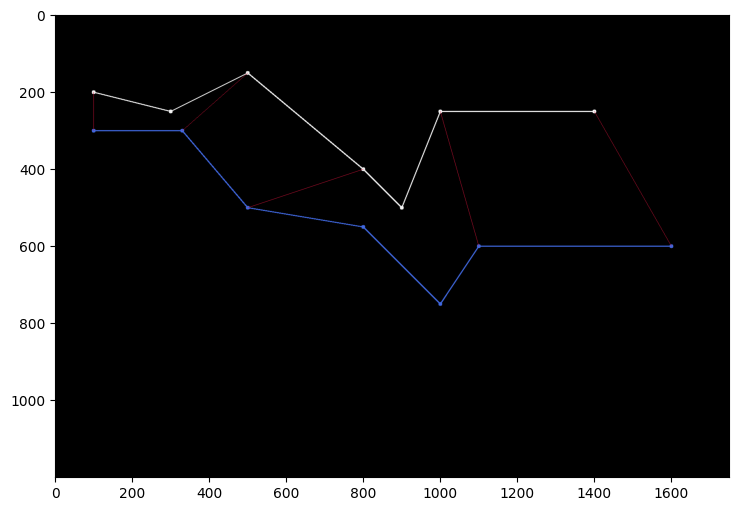

In [17]:
'''
tracks14_frechet_img = tracks14_img.copy()
illustrate_frechet(tracks14_frechet_img, tracks[0], tracks[3])
show_img(tracks14_frechet_img)
'''
curve_1 = np.array([[100, 200], [300, 250], [500, 150], [800, 400], [900, 500], [1000, 250], [1400, 250]])
curve_2 = np.array([[100, 300], [330, 300], [500, 500], [800, 550], [1000, 750], [1100, 600], [1600, 600]])
curves_frechet_img = draw_tracks(np.zeros(shape, np.uint8), [curve_1, curve_2])
illustrate_frechet(curves_frechet_img, curve_1, curve_2)
show_img(curves_frechet_img, (9, 6))


Вычислим все попарные расстояния Фреше: $F(i,j)$:

In [18]:
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        f_dst = my_frechet_dst(tracks[i], tracks[j])
        print('F(', i + 1, ',', j + 1,  ') = ', '%.3f' % f_dst)

F( 1 , 2 ) =  144.003
F( 1 , 3 ) =  60.729
F( 1 , 4 ) =  212.177
F( 2 , 3 ) =  133.143
F( 2 , 4 ) =  244.048
F( 3 , 4 ) =  210.620


Установим библиотеку, позволяющую вычислять расстояние Фреше и вычислим расстояния $F'(i,j)$:

In [19]:
%pip install similaritymeasures


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import similaritymeasures

In [21]:
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        f_dst = similaritymeasures.frechet_dist(tracks[i], tracks[j])
        print('F\'(', i + 1, ',', j + 1,  ') = ', '%.3f' % f_dst)

F'( 1 , 2 ) =  144.003
F'( 1 , 3 ) =  60.729
F'( 1 , 4 ) =  212.177
F'( 2 , 3 ) =  133.143
F'( 2 , 4 ) =  244.048
F'( 3 , 4 ) =  210.620


Сравниние расстояний Фреше для исходных и траекторий и траекторий после разбиения дает результат похожий на то, что мы видили, сравнивая расстояния по Хаусдорфу:

In [22]:
print('Frechet distance:')
print('i j  ', 'original', ' splitted')
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        splitted_f_dst = my_frechet_dst(tracks[i], tracks[j])
        original_f_dst = my_frechet_dst(original_tracks[i], original_tracks[j])
        print(i + 1, j + 1, ' ', '%.3f' % original_f_dst, ' ', '%.3f' % splitted_f_dst)

Frechet distance:
i j   original  splitted
1 2   170.883   144.003
1 3   167.287   60.729
1 4   225.056   212.177
2 3   191.604   133.143
2 4   258.496   244.048
3 4   266.062   210.620


Видно, что расстояние между траекториями 1 и 3 сильно увеличивается за счет последнего красного отрезка. 

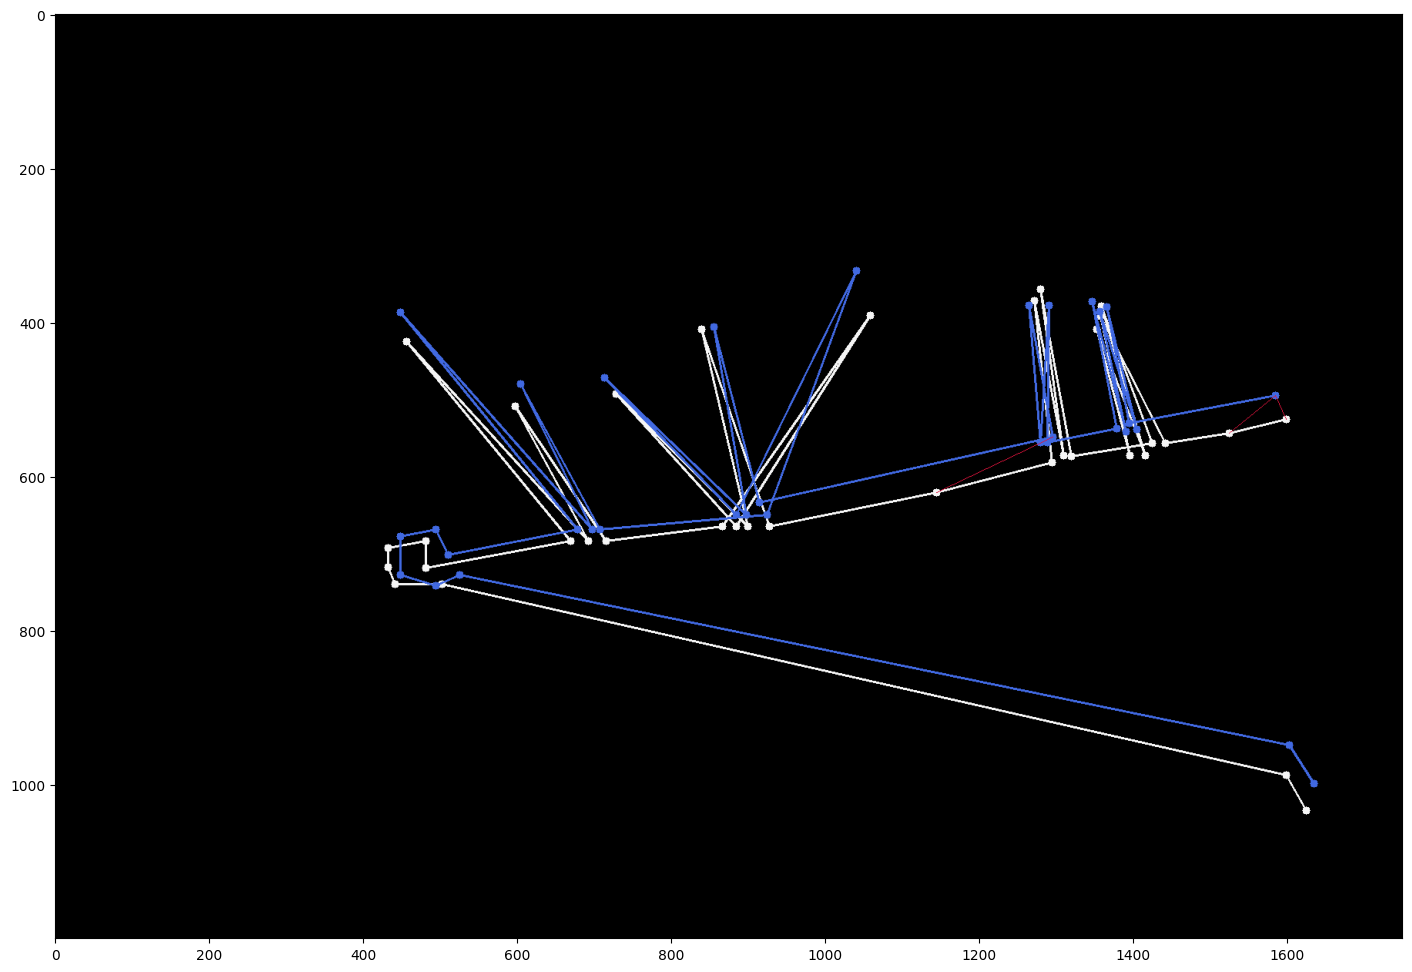

In [23]:
tracks13_frechet_img = np.zeros(shape, np.uint8)
tracks13_frechet_img = draw_tracks(tracks13_frechet_img, [original_tracks[0], original_tracks[2]])
illustrate_frechet(tracks13_frechet_img, original_tracks[0], original_tracks[2])
show_img(tracks13_frechet_img)

Наивный алгоритм
=

**Описание алгоритма:**

В данном алгоритме мы будем сравнивать две траектории поточечно. Точки траекторий из входного файла записаны через одинаковые интервалы времени, поэтому может иметь смысл считать за расстояние между траекториями $P = (v_1, ..., v_n), Q = (u_1, ..., u_n)$ расстояние $d(P, Q)$, вычисляемое по формуле: $d(P, Q) = \max_{i \in 1..n} \{ d(v_i, u_i) \}$. 

Решать вопрос несоответсвия размеров $|P|$ и $|Q|$ можно по-разному. В данном алгоритме мы добавим в траекторию меньшего размера нужное количество последних точек: 

$P = (v_1, ..., v_p), Q = (u_1, ..., u_q), p < q \to P = (v_1, ..., v_p, v_{p+1} = v_p, ..., v_q = v_p)$, $Q = (u_1, ..., u_q)$.

**Оценка времени работы:**


Очевидно, что данный алгоритм работает за $O(\max\{ |P|, |Q| \})$ времени.

In [24]:
n_dst_1_4 = my_naive_dst(tracks[0], tracks[3])
print('"Наивное" расстояние между траекториями 1 и 4  =', '%.3f' % n_dst_1_4)

"Наивное" расстояние между траекториями 1 и 4  = 1300.945


Продемонстрируем его работу на паре уже знакомых кривых. Красными отрезками соединены точки с одинаковыми порядковыми номерами. Искомая расстояение – длина наибольшего красного отрезка.

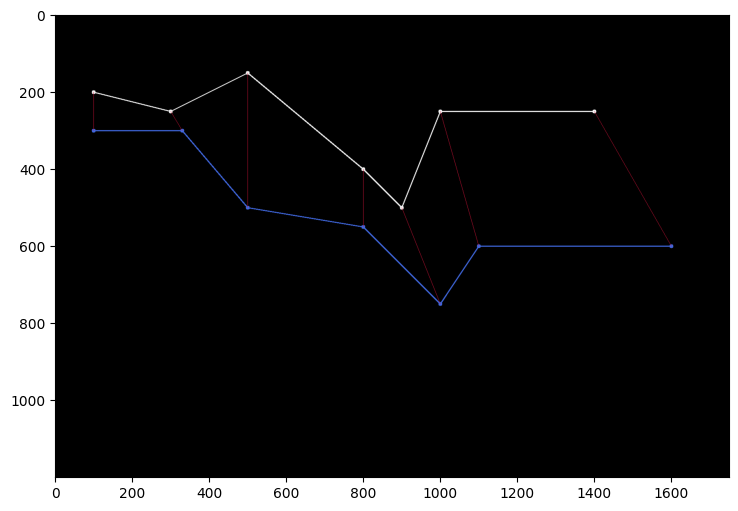

In [25]:
curves_naive_img = draw_tracks(np.zeros(shape, np.uint8), [curve_1, curve_2])
illustrate_naive(curves_naive_img, curve_1, curve_2)
show_img(curves_naive_img, (9,6))

На тестовых данных наивный алгоритм работает совсем плохо. Даже у похожих траекторий 1 и 3 разное количество опорных точек (35 и 19), поэтому точки с одинаковым порядковым номером могут находится на большом расстоянии друг от друга. Этот факт можно пронаблюдать ниже: 

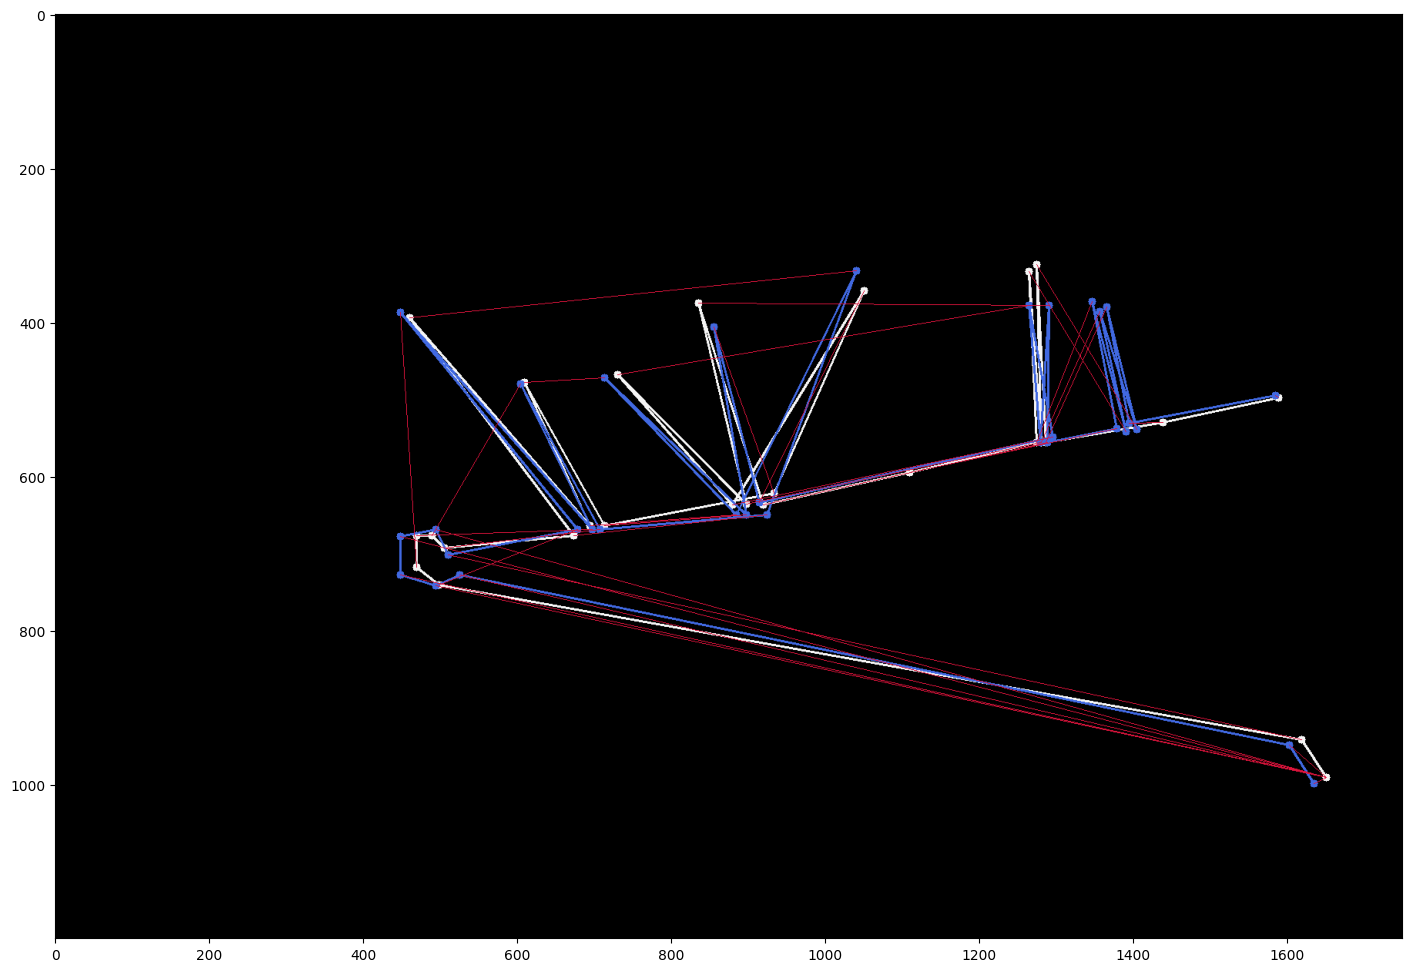

In [26]:
tracks23_naive_img = draw_tracks(np.zeros(shape, np.uint8), [original_tracks[1], original_tracks[2]])
illustrate_naive(tracks23_naive_img, original_tracks[1], original_tracks[2])
show_img(tracks23_naive_img)

Посчитаем расстояния $N(i,j)$ наивным алгоритмом для всех пар заданных траекторий:

In [27]:
print('Naive distance:')
print('i j  ', 'original', ' splitted')
for i in range(len(tracks)):
    for j in range(i + 1, len(tracks)):
        splitted_n_dst = my_naive_dst(tracks[i], tracks[j])
        original_n_dst = my_naive_dst(original_tracks[i], original_tracks[j])
        print(i + 1, j + 1, ' ', '%.3f' % original_n_dst, ' ', '%.3f' % splitted_n_dst)

Naive distance:
i j   original  splitted
1 2   1271.823   1221.781
1 3   1179.662   293.898
1 4   1300.945   1300.945
2 3   1242.084   1171.517
2 4   1311.543   1197.097
3 4   1325.423   1325.423


Вывод
==

Если мы хотим учитывать направление траектории, то необходимо использовать расстояние Фреше. Если мы сравниваем траектории как множество точек из $\mathbb{R}^2$ и нам не интересна другая информация, то можно использовать расстояние по Хаусдорфу. При этом для большей точности следует разделить траекторию на более мелкие отрезки.


Если при подсчете расстояния Фреше нам важна информация количестве опорных точек в траектории и/или времени их детекции, то необходимо сравнивать исходные траектории. Если же нас интересует только направление движения вдоль траектории, то ее так же можно разбить на более мелкие сегменты.
